In [1]:
import openturns as ot
from openturns.viewer import View
import numpy as np
from matplotlib import pylab as plt

# Step A: define the physical model

In [2]:
model = ot.SymbolicFunction(["F", "E", "L", "I"], ["F*L^3/(3*E*I)"])
model = ot.MemoizeFunction(model)
model.enableCache()

# Step B: specify the input random vector # 

In [3]:
# Young modulus from data
sample_E = ot.Sample.ImportFromCSVFile("sample_E.csv") 
kernel_smoothing = ot.KernelSmoothing(ot.Normal())
bandwidth = kernel_smoothing.computeSilvermanBandwidth(sample_E)
E = kernel_smoothing.build(sample_E, bandwidth)
E.setDescription(['Young modulus'])

# Load
F = ot.LogNormal()
F.setParameter(ot.LogNormalMuSigma()([30000, 9000, 15000]))
F.setDescription(['Load'])

# beam Length
L = ot.Uniform(250, 260)
L.setDescription(['Length'])

# Inertia
I = ot.Beta(2.5, 4, 310, 450)
I.setDescription(['Inertia'])

# 
marginal_distributions = [F, E, L, I]

# add copula
SR_cor = ot.CorrelationMatrix(len(marginal_distributions))
SR_cor[2, 3] = -0.2
copula = ot.NormalCopula(ot.NormalCopula.GetCorrelationFromSpearmanCorrelation(SR_cor))

# 
input_distribution = ot.ComposedDistribution(marginal_distributions, copula)
dimension = input_distribution.getDimension()

In [4]:
input_random_vector = ot.RandomVector(input_distribution)

# Step C: uncertainty propagation

A kriging metamodel is used.

## Dataset: input and output
For input, a Monte Carlo sample can be used. For a more efficient approach, a space filling Design of Experiments can be used

In [5]:
design_of_experiments = ot.MonteCarloExperiment(input_distribution, 100)
input_sample = design_of_experiments.generate()
output_sample = model(input_sample)

# Data Preprocessing
In some cases, it could be necessary to transform your data before trying to fit a model on it.
In this notebook, we chose the kriging metamodel. It will search for some optimal parameter values, and it is sensitive to the order of magnitude of the physical parameters.But, keep in mind the metamodel you built is based on normalized output !

Here is an example of function to transform your data, like $x_{norm} = \frac{x - x_{mean}}{std(x)}$.

In [7]:
# Create of a normalized data set: linear transformation
mean = input_sample.computeMean()
stddev = input_sample.computeStandardDeviation()
linear = ot.SquareMatrix(dimension)

for j in range(dimension):
    linear[j, j] = 1.0 / stddev[j] if abs(stddev[j]) > 1e-12 else 1.0
zero = [0.0] * dimension

transformation = ot.LinearFunction(mean, zero, linear)

normalized_inputSample = transformation(input_sample)

# Kriging model preparation

## Specification of the basis

We can use existing basis factory : ConstantBasisFactory, LinearBasisFactory, QuadraticBasisFactory, or create our own basis using a collection of NumericalMathFunction and transform it into a basis.

In [8]:
basis = ot.ConstantBasisFactory(dimension).build()
print(basis)

Basis( [class=LinearEvaluation name=Unnamed center=[0,0,0,0] constant=[1] linear=[[ 0 ]
 [ 0 ]
 [ 0 ]
 [ 0 ]]] )


## Specification of the covariance model

The covariance model can be a model of dimension corresponding of the input dimension. Or it can be a product covariance model where each input has its own covariance mode of dimension 1. If the output dimension is greater than 1, the user can provide a tensorized covariance model.

In [9]:
# we create a product covariance model where each input has its own covariance model
covColl = ot.CovarianceModelCollection(dimension)
for i in range(dimension):
    covColl[i]  = ot.SquaredExponential([1])
covarianceModel = ot.ProductCovarianceModel(covColl)

# if input sample is not normalized, it could be crucial to set the right scale to speed up the regression
covarianceModel.setScale(input_sample.getMax())

In [10]:
# kriging on non normalized input, but with starting point at good order of magnitude.
kriging_algorithm = ot.KrigingAlgorithm(input_sample, 
                                        output_sample, 
                                        covarianceModel, basis)

# set the global optimization algorithm to improve the optimization result
kriging_algorithm.setOptimizationAlgorithm(ot.NLopt('GN_DIRECT'))
#kriging_algorithm.setOptimizeParameters(False)

# combined with the scale of the covariance model, we can help the algorithm to search in the right area.
scaleOptimizationBounds = ot.Interval(input_sample.getMin(), input_sample.getMax())
kriging_algorithm.setOptimizationBounds(scaleOptimizationBounds)



WRN - Warning! For coherency we set scale upper bounds = [131125,3.8492e+07,19.5488,241.076]


## Running the kriging algorithm

In [11]:
kriging_algorithm.run()

In [12]:
kriging_result = kriging_algorithm.getResult()
metamodel = kriging_result.getMetaModel()
covarianceModel = kriging_result.getCovarianceModel()
print( 'Covariance model parameters : {}'.format(kriging_result.getCovarianceModel().getScale()))
print( 'Covariance model amplitude : {}'.format(kriging_result.getCovarianceModel().getAmplitude()))

Covariance model parameters : [83544.3,3.22669e+07,250.236,413.599]
Covariance model amplitude : [88.9556]


## Assess the metamodel goodness-of-fit

In [13]:
def computeLOO(inputSample, outputSample, krigingResult):
    """
    Compute the Leave One out prediction analytically (from Dubrule 1983 paper).
    """
    inputSample = np.array(inputSample)
    outputSample = np.array(outputSample)

    # get covariance model
    cov = krigingResult.getCovarianceModel()
    # get coefficient and compute trend
    basis = krigingResult.getBasisCollection()[0]
    F1 = krigingResult.getTrendCoefficients()[0]
    size = inputSample.shape[0]
    p = F1.getDimension()
    F = np.ones((size, p))
    for i in range(p):
        F[:, i] = np.hstack(basis.build(i)(normalized_inputSample))
    # Calcul de y_loo
    K = np.array(cov.discretize(normalized_inputSample))
    Z = np.zeros((p, p))
    S = np.vstack([np.hstack([K, F]), np.hstack([F.T, Z])])
    S_inv = np.linalg.inv(S)
    B = S_inv[:size:, :size:]
    B_but_its_diag = B * (np.ones(B.shape) - np.eye(size))
    B_diag = np.atleast_2d(np.diag(B)).T
    y_loo = (- np.dot(B_but_its_diag / B_diag, outputSample)).ravel()
    return ot.Sample(np.vstack(y_loo))

In [14]:
def computeQ2(inputSample, outputSample, krigingResult):
    """
    Compute the Q2 using the analytical loo prediction.
    """
    y_loo = np.hstack(computeLOO(inputSample, outputSample, krigingResult))
    # Calcul du Q2
    delta = (np.hstack(outputSample) - y_loo)
    Q2 = 1 - np.mean(delta**2)/np.var(outputSample)
    return Q2

As kriging is an interpolating technique, R2 value is 1 so it does not provide useful information about the kriging model quality. It is more relevant to compute the Q2 using the leave-one out prediction.

In [15]:
validation = ot.MetaModelValidation(input_sample, output_sample, metamodel)
print( 'R2 : ', validation.computePredictivityFactor())
print( 'Q2 : ', computeQ2(input_sample, output_sample, kriging_result))

R2 :  [1]
Q2 :  0.9478307139361264


### Adequation plot on leave-one out predictions

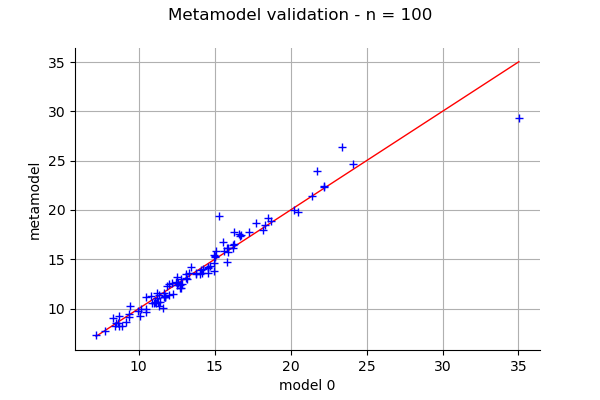

In [16]:
output_LOO = computeLOO(input_sample, output_sample, kriging_result)
validation = ot.MetaModelValidation(input_sample, output_LOO, metamodel)
validation.drawValidation()

### Superposition of the model and the metamodel in 1D cuts

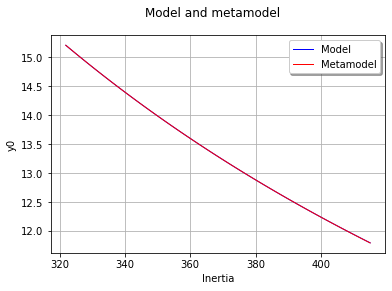

In [17]:
input_number = 3
input_margin = input_distribution.getMarginal(input_number)
model_cut = model.draw(input_number,
                       0,
                       input_distribution.getMean(),
                       input_margin.computeQuantile(.025)[0],
                       input_margin.computeQuantile(.975)[0],
                       100).getDrawable(0)
metamodel_cut = metamodel.draw(input_number,
                               0,
                               input_distribution.getMean(),
                               input_margin.computeQuantile(.025)[0],
                               input_margin.computeQuantile(.975)[0],
                               100).getDrawable(0)

graph = ot.Graph("Model and metamodel", "", "", True)
graph.add([model_cut, metamodel_cut])
graph.setColors(["blue", "red"])
graph.setLegends(["Model", "Metamodel"])
graph.setXTitle(input_margin.getDescription()[0])
graph.setYTitle(model.getOutputDescription()[0])
graph.setLegendPosition("topright")
view = View(graph)

### Reliability analysis using a (large) Monte Carlo sample of the kriging approximation

In [18]:
krigingRandomVector = ot.CompositeRandomVector(metamodel, ot.RandomVector(input_distribution))
event = ot.ThresholdEvent(krigingRandomVector, ot.Greater(), 30.) 
event.setName("Deviation > %s cm" % event.getThreshold())

### PDF and CDF approximations

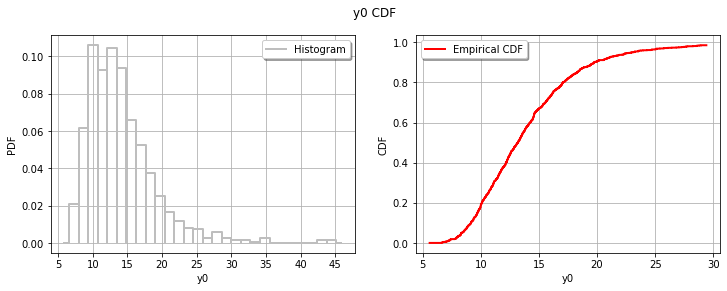

In [19]:
sample = krigingRandomVector.getSample(1000)
fig = plt.figure(figsize=(12, 4))
ax_pdf = fig.add_subplot(1, 2, 1)
hist_E = ot.HistogramFactory().build(sample).drawPDF()
hist_E.setColors(["gray"])
hist_E.setLegends(["Histogram"])
_ = View(hist_E, figure=fig, axes=[ax_pdf])
ax_cdf = fig.add_subplot(1, 2, 2)
ecdf_E = ot.UserDefined(sample).drawCDF()
ecdf_E.setLegends(["Empirical CDF"])
_ = View(ecdf_E, figure=fig, axes=[ax_cdf])

In [20]:
experiment = ot.MonteCarloExperiment()
MCS_algorithm = ot.ProbabilitySimulationAlgorithm(event, experiment)
MCS_algorithm.setMaximumOuterSampling(40000) 
MCS_algorithm.setBlockSize(1) 
MCS_algorithm.setMaximumCoefficientOfVariation(.1)
MCS_algorithm.run()
MCS_result = MCS_algorithm.getResult()

In [21]:
print( "Proability estimate = %.2e" % MCS_result.getProbabilityEstimate() )
print( "Coefficient of variation = %.2f" % MCS_result.getCoefficientOfVariation())
print( "95%% Confidence Interval = [%.2e, %.2e]" % (MCS_result.getProbabilityEstimate() - .5 * MCS_result.getConfidenceLength(0.95),
                                                    MCS_result.getProbabilityEstimate() + .5 * MCS_result.getConfidenceLength(0.95)))

Proability estimate = 1.05e-02
Coefficient of variation = 0.10
95% Confidence Interval = [8.47e-03, 1.26e-02]


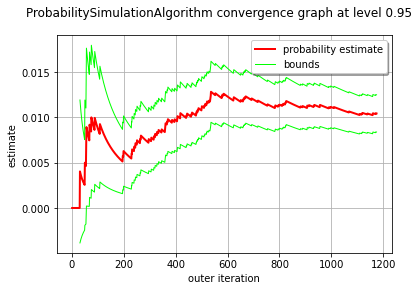

In [22]:
_ = View(MCS_algorithm.drawProbabilityConvergence(.95))